# Predicting the stock market

The [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) is a stock market index tracking the stock performance of 500 of the largest companies listed on stock exchanges in the United States. 

In this project, we'll use historic data of the S&P 500 to make predictions about the future, with a linear regression model. The goal is merely to practice my machine learning skills. It is explicitly **not** recommended to use outcome and model as any trading advice.

On many websites the index can be followed, and historic data can be found. I will make use though of a file that was provided by [Dataquest](https://www.dataquest.io/) and can be downloaded from [one of their course pages](https://app.dataquest.io/c/11/m/65/guided-project%3A-predicting-the-stock-market/1/the-dataset?path=2&slug=data-scientist&version=1.2). (You need a Dataquest account for that.) It contains historic data from 1950 to 2015.

Structure of this notebook:
* 1.Preparations, data exploration and cleaning
* 2.Enrich data with potential predictors
    * 2.1 Calculate potential predictors
    * 2.2 Transform data for machine learning
* 3.Train and use a linear regression model
    * 3.1 Split in train and test
    * 3.2 Build linear regression model
    * 3.3 Prepare feature selection (numerical only)
    * 3.4 Test with various selections of numerical features
    * 3.5 Adding categorical features (month, day)
* 4.Trying to improve the model
    * 4.1 Rolling horizon
    * 4.2 Use less historical data
* 5.Conclusions and possible next steps

## 1. Preparations, data exploration and cleaning

In this section we will do some preparations such as importing all libraries, import the data, do some exploration and cleaning to make it suitable for next steps.

In [1]:
# Import libraries (and enable plotting)
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

In [2]:
# Always display all columns in the output
pd.options.display.max_columns = None

In [3]:
# Import the data
sphist = pd.read_csv('sphist.csv')

# Show basic info
sphist.info()

# Show a sample
sphist.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
Date         16590 non-null object
Open         16590 non-null float64
High         16590 non-null float64
Low          16590 non-null float64
Close        16590 non-null float64
Volume       16590 non-null float64
Adj Close    16590 non-null float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117


So we have 16590 rows, without any missing data. There is one row for every trading day (not for every calendar day). For every trading day we have the value of the S&P 500 index at opening, the highest and lowest value during the day, and at closing, as well as the trading value. (I will get back to the 'adjusted close'.)

The only data transformation to do is to convert the Date column to a Datetime. Also, for convenience, I will sort the data from old to new.

In [4]:
# Convert Date column to a datetime
sphist['Date'] = pd.to_datetime(sphist['Date'])

# Sort dataframe on date, ascending
sphist.sort_values(by = 'Date', ascending = True, inplace = True)

# To validate, show top 3 rows and bottom 3 rows
print(sphist.head(3))
print(sphist.tail(3))

            Date   Open   High    Low  Close     Volume  Adj Close
16589 1950-01-03  16.66  16.66  16.66  16.66  1260000.0      16.66
16588 1950-01-04  16.85  16.85  16.85  16.85  1890000.0      16.85
16587 1950-01-05  16.93  16.93  16.93  16.93  2550000.0      16.93
        Date         Open         High          Low        Close  \
2 2015-12-03  2080.709961  2085.000000  2042.349976  2049.620117   
1 2015-12-04  2051.239990  2093.840088  2051.239990  2091.689941   
0 2015-12-07  2090.419922  2090.419922  2066.780029  2077.070068   

         Volume    Adj Close  
2  4.306490e+09  2049.620117  
1  4.214910e+09  2091.689941  
0  4.043820e+09  2077.070068  


To get an impression of the historic development of the S&P 500 index, let's show a line graph of the Close value.

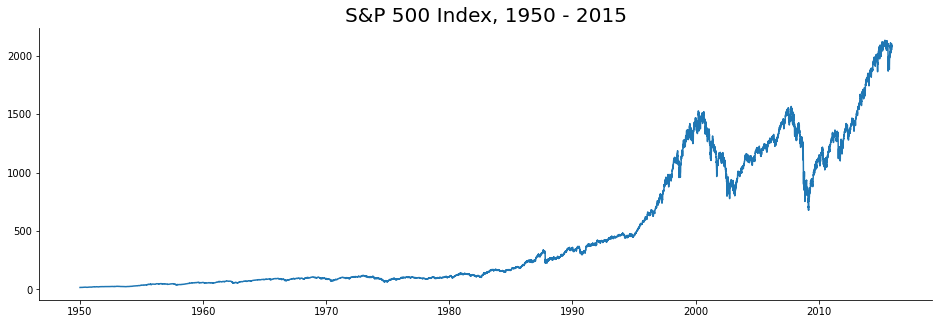

In [5]:
# Show a line graph
fig,ax = plt.subplots(figsize=(16, 5))
plt.plot(sphist['Date'],sphist['Close'])
plt.title('S&P 500 Index, 1950 - 2015', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

The adjusted closing price of stock accounts for any changes that happen due to corporate actions like dividends, stock splits, and others after trading hours.

Also the index (in essence being a combination of multiple stocks) has an Adjusted Close. If this is different from the Close price, then this may impact our predictive model. Let's check which cases we have.

In [6]:
# Check for cases where the "Adj Close" differs from "Close"
sphist[sphist['Close'] != sphist['Adj Close']]

,Date,Open,High,Low,Close,Volume,Adj Close


There are none. So we don't need to worry about this.

## 2. Enrich data with potential predictors

In this section, we're going to add multiple attributes to each row that are possibly meaningful for prediction of the index.

### 2.1 Calculate potential predictors

We'll add:
* the mean closing price of the past 5 trading days
* the mean closing price of the past 30 trading days
* the mean closing prices of the past 365 trading days (this is actually a year and several months)
* the ratio between the mean closing price of the past 5 vs the mean closing price of the past 365 closing days
* the trading volume of the previous trading day
* the month of the trading day
* the day of the week of the trading day

In [7]:
# For every row, calculate the mean closing price of the past 5 trading days
sphist['meanpast5days'] = sphist['Close'].rolling(5).mean()

# This 'rolling' value that was calculated now is for five days, but including the closing price of the day itself (which should not be the case)
# To address, shift the values one row down
sphist['meanpast5days'] = sphist.meanpast5days.shift(1)

# Show the first 10 rows
sphist.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,meanpast5days
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN
16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900
16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974
16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022
16581,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988
16580,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926


In [8]:
# Validate the correctness of the attribute
print ('First calculated value is 16.900 and should be', (16.66 + 16.85 + 16.93 + 16.98 +17.08)/5)

First calculated value is 16.900 and should be 16.9


In [9]:
# Show bottom 3 rows (to ensure nothing went wrong with the shifting at the final rows)
sphist.tail(3)

,Date,Open,High,Low,Close,Volume,Adj Close,meanpast5days
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2080.771973


In [10]:
# In the same way, calculate the mean of the past 30 and the past 365 (trading) days
sphist['meanpast30days'] = sphist['Close'].rolling(30).mean()
sphist['meanpast30days'] = sphist.meanpast30days.shift(1)

sphist['meanpast365days'] = sphist['Close'].rolling(365).mean()
sphist['meanpast365days'] = sphist.meanpast365days.shift(1)

# Add another indicator: the ratio between the mean of the past 5 days and of the past 365 days
sphist['ratiopast5vspast365'] = sphist['meanpast5days']/sphist['meanpast365days']

# Add another indicator: the volume of the past day
sphist['volprevday'] = sphist['Volume'].rolling(1).mean()
sphist['volprevday'] = sphist.volprevday.shift(1)

# Show some rows around the 365th row, which should be the first to have all values
sphist[363:368]

,Date,Open,High,Low,Close,Volume,Adj Close,meanpast5days,meanpast30days,meanpast365days,ratiopast5vspast365,volprevday
16226,1951-06-15,22.040001,22.040001,22.040001,22.040001,1370000.0,22.040001,21.602,21.753000,NaN,NaN,1300000.0
16225,1951-06-18,22.049999,22.049999,22.049999,22.049999,1050000.0,22.049999,21.712,21.727333,NaN,NaN,1370000.0
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726,1.120954,1050000.0
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411,1.125246,1100000.0
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274,1.128142,1120000.0


That all looks good.

In [11]:
# Add month of the year
sphist['month'] = sphist['Date'].dt.month

# Add day of the week
sphist['dayofweek'] = sphist['Date'].dt.weekday_name

# Show some rows to validate the month
print(sphist[['Date','month']].sample(5))

# Show the day of week of a date for which I know it was a Tuesday
print(sphist[sphist['Date'] == '1972-04-18']['dayofweek'])

            Date  month
6966  1988-04-19      4
7496  1986-03-14      3
13008 1964-04-06      4
11035 1972-03-09      3
8684  1981-07-02      7
11008    Tuesday
Name: dayofweek, dtype: object


Looks good.

Rows with NaN values cannot be used for machine learning. (We saw above we have some now by adding 'meanNNdays' columns. We'll drop those rows.

In [12]:
# Remove any rows that contain NaN values (as they cannot be used for machine learning)
sphist.dropna(axis = 0, inplace = True)

# To validate, show the first few remaining rows (should start with 1951-06-19)
sphist.head(3)

,Date,Open,High,Low,Close,Volume,Adj Close,meanpast5days,meanpast30days,meanpast365days,ratiopast5vspast365,volprevday,month,dayofweek
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726,1.120954,1050000.0,6,Tuesday
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411,1.125246,1100000.0,6,Wednesday
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274,1.128142,1120000.0,6,Thursday


In [13]:
# Let's double-check whether indeed we have a dataframe now containing 365 less rows than before (so that is 16225), and without any missing data.
sphist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16225 entries, 16224 to 0
Data columns (total 14 columns):
Date                   16225 non-null datetime64[ns]
Open                   16225 non-null float64
High                   16225 non-null float64
Low                    16225 non-null float64
Close                  16225 non-null float64
Volume                 16225 non-null float64
Adj Close              16225 non-null float64
meanpast5days          16225 non-null float64
meanpast30days         16225 non-null float64
meanpast365days        16225 non-null float64
ratiopast5vspast365    16225 non-null float64
volprevday             16225 non-null float64
month                  16225 non-null int64
dayofweek              16225 non-null object
dtypes: datetime64[ns](1), float64(11), int64(1), object(1)
memory usage: 1.9+ MB


Looks good!

For next steps, it is helpful if we have lists containing all the features that we added.

In [14]:
# Create two lists with all features that we added
features_numerical = ['meanpast5days','meanpast30days','meanpast365days', 'ratiopast5vspast365','volprevday']
features_categorical = ['month', 'dayofweek']

### 2.2 Transform data for machine learning

We'll do some transformations for the newly added columns to get our data fully ready for machine learning:
* normalize the numerical features
* dummy-code the categorical features

In [15]:
# Add normalized columns for the numerical features
scaler = MinMaxScaler()
for feature in features_numerical:
    column = sphist[feature]
    newcolumnname = column.name + '_norm'
    sphist[newcolumnname] = scaler.fit_transform(column.values.reshape(-1,1))

In [16]:
# Show statistics to validate the result
sphist.describe()

,Open,High,Low,Close,Volume,Adj Close,meanpast5days,meanpast30days,meanpast365days,ratiopast5vspast365,volprevday,month,meanpast5days_norm,meanpast30days_norm,meanpast365days_norm,ratiopast5vspast365_norm,volprevday_norm
count,16225.000000,16225.000000,16225.000000,16225.000000,1.622500e+04,16225.000000,16225.000000,16225.000000,16225.000000,16225.000000,1.622500e+04,16225.000000,16225.000000,16225.000000,16225.000000,16225.000000,16225.000000
mean,492.989430,496.111413,489.713924,493.113714,8.118274e+08,493.113714,492.733633,491.147987,470.198776,1.054860,8.115782e+08,6.538059,0.223838,0.224789,0.223429,0.663632,0.070786
std,556.682208,559.983949,553.154323,556.800880,1.467969e+09,556.800880,556.376404,554.598919,530.252490,0.106731,1.467763e+09,3.428805,0.264086,0.265420,0.262837,0.144675,0.128127
min,20.959999,20.959999,20.959999,20.959999,6.800000e+05,20.959999,21.152000,21.449333,19.447726,0.565281,6.800000e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,86.529999,87.279999,85.849998,86.529999,9.280000e+06,86.529999,86.507999,86.409667,86.496219,0.995095,9.280000e+06,4.000000,0.031021,0.031089,0.033235,0.582619,0.000751
50%,159.880005,160.500000,158.710007,159.880005,8.201000e+07,159.880005,159.392001,158.110667,141.402795,1.069560,8.201000e+07,7.000000,0.065616,0.065403,0.060451,0.683557,0.007100
75%,977.460022,985.750000,968.650024,977.590027,8.526000e+08,977.590027,976.965991,970.956004,979.091619,1.124854,8.516000e+08,10.000000,0.453680,0.454415,0.475678,0.758509,0.074280
max,2130.360107,2134.719971,2126.060059,2130.820068,1.145623e+10,2130.820068,2127.952051,2110.963013,2036.869425,1.303009,1.145623e+10,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Looks good. All normalized columns range from 0 to 1.

In [17]:
# Dummy code categorical features (so we can use them for a linear regression model)
for feature in features_categorical:
    to_add = pd.get_dummies(sphist[feature], prefix = feature, drop_first = False)
    sphist = sphist.join(to_add)
    sphist = sphist.drop(feature, axis = 1)

In [18]:
# Validate result for a date in the past; should be month_4 and dayofweek_Tuesday
sphist[sphist['Date'] == '1972-04-18']

,Date,Open,High,Low,Close,Volume,Adj Close,meanpast5days,meanpast30days,meanpast365days,ratiopast5vspast365,volprevday,meanpast5days_norm,meanpast30days_norm,meanpast365days_norm,ratiopast5vspast365_norm,volprevday_norm,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_Friday,dayofweek_Monday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
11008,1972-04-18,109.510002,110.639999,109.019997,109.769997,19410000.0,109.769997,109.840001,108.299333,98.767616,1.112105,15390000.0,0.042096,0.041565,0.039317,0.741228,0.001284,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


Looks good.

As a final preparation step, let's create some more lists that will be helpful in next steps.

In [19]:
# Create three more lists that we will use in next steps (and print to validate)
features_numerical_normalized = sphist.columns[sphist.columns.str.endswith('norm')].tolist()
print(features_numerical_normalized)
features_month = sphist.columns[sphist.columns.str.startswith('month')].tolist()
print(features_month)
features_dayofweek = sphist.columns[sphist.columns.str.startswith('day')].tolist()
print(features_dayofweek)

['meanpast5days_norm', 'meanpast30days_norm', 'meanpast365days_norm', 'ratiopast5vspast365_norm', 'volprevday_norm']
['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
['dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday']


## 3. Train and use a linear regression model

In this section we'll build the linear regression model. The model will be trained first on the 'training' data, then predictions will be done on the 'test' data. By comparing the predicted values with the actual values (in the form of an error metric), we can say something about the quality of the model. We'll do this with several combinations of the features that were added in the previous section.

'Close', the closing value of the index on a trading day, will be the target column, the one that we are trying to predict.

The error metric that will be used is the 'mean absolute error'. Main reason to select this one is that its value is relatively easy to interpret as a human.

### 3.1 Split in train and test

Most data will be used to train the model. Testing will be done for the final 2.5 years in the data.


In [20]:
# Split the data in train (data before 2013) and test (data from 2013 onwards)
train = sphist[sphist['Date'] < '2013-01-01']
test = sphist[sphist['Date'] >= '2013-01-01']

In [21]:
# To validate, show the last three rows of train (should be late 2012)
train.tail(3)

,Date,Open,High,Low,Close,Volume,Adj Close,meanpast5days,meanpast30days,meanpast365days,ratiopast5vspast365,volprevday,meanpast5days_norm,meanpast30days_norm,meanpast365days_norm,ratiopast5vspast365_norm,volprevday_norm,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_Friday,dayofweek_Monday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
741,2012-12-27,1419.829956,1422.800049,1401.800049,1418.099976,2.830180e+09,1418.099976,1431.228003,1408.813000,1326.716494,1.078775,2.285030e+09,0.669297,0.663965,0.647990,0.696048,0.199410,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
740,2012-12-28,1418.099976,1418.099976,1401.579956,1402.430054,2.426680e+09,1402.430054,1427.685986,1410.265332,1326.995836,1.075878,2.830180e+09,0.667616,0.664660,0.648128,0.692122,0.246998,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
739,2012-12-31,1402.430054,1426.739990,1398.109985,1426.189941,3.204330e+09,1426.189941,1419.434009,1411.830001,1327.261562,1.069446,2.426680e+09,0.663699,0.665409,0.648260,0.683402,0.211775,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [22]:
# And the first three rows of test (should be early 2013)
test.head(3)

,Date,Open,High,Low,Close,Volume,Adj Close,meanpast5days,meanpast30days,meanpast365days,ratiopast5vspast365,volprevday,meanpast5days_norm,meanpast30days_norm,meanpast365days_norm,ratiopast5vspast365_norm,volprevday_norm,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_Friday,dayofweek_Monday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
738,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1327.534055,1.068629,3.204330e+09,0.663324,0.666571,0.648395,0.682296,0.279659,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
737,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1417.676668,1327.908247,1.073714,4.202600e+09,0.666718,0.668207,0.648581,0.689188,0.366802,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
736,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1420.092668,1328.224877,1.079412,3.829730e+09,0.670472,0.669363,0.648738,0.696912,0.334253,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### 3.2 Build linear regression model

We'll create a train-and-test function so that we can later efficiently test with different sets of feautures, and then immediately get the results.

In [23]:
# Create a function with as inputs the features to use, and as output the mean-absolute-error of the predictions in the test set
# For validation purposes, optionally details can be printed

def train_and_test (features, printdetails = False):
    lr = LinearRegression()
    
    # Set the target column (the one we try to predict)
    target = 'Close'
    
    # Train the model
    lr.fit(train[features], train[target])

    # Calculate predictions on test dataset
    test_predictions = lr.predict(test[features])
    
    # Print header
    print('Features used:', features)
    
    # Print details (optionally)
    if printdetails:
        print('\nFirst five predictions:\n')
    
        # Show a sample: the first 5 predictions vs the first 5 values that it tried to predict:
        for i in range(0,5):
            print ('Predicted value:', test_predictions[i], '; actual value:', test.iloc[i][target])
    
        # Show parameters of the model
        print ('\nIntercept:', lr.intercept_)
        for i in range(0, len(features)):
            print ('Parameter',features[i],': coefficient', lr.coef_[i])
    
    # Calculate (and return) mean absolute error of the predictions
    mean_abs_error = mean_absolute_error(test[target], test_predictions)
    return mean_abs_error    

In [24]:
# Try out train-and-test with two of the features
selected_features = ['meanpast5days', 'volprevday']
result = train_and_test (selected_features, printdetails = True)
print('\nMean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'volprevday']

First five predictions:

Predicted value: 1418.8918568536956 ; actual value: 1462.420044
Predicted value: 1425.5430795646255 ; actual value: 1459.369995
Predicted value: 1433.6516407665642 ; actual value: 1466.469971
Predicted value: 1443.545083898521 ; actual value: 1461.890015
Predicted value: 1455.5132035455617 ; actual value: 1457.150024

Intercept: 0.07576413667266024
Parameter meanpast5days : coefficient 1.0012764654044253
Parameter volprevday : coefficient -5.107922427751727e-10

Mean absolute error of the predictions: 16.231536567068034


Interesting to see the initial results. The mean absolute error is just above 16, however from the first 5 predictions we can already observe there is quite some spread.

Earlier we added normalized versions of the numeric features as well. I was actually not 100% sure whether that is even relevant (as I think a linear regression model as such can deal with it and just come with different coefficients but the same results). This is a nice opportunity to check that.

In [25]:
# Check whether normalization matters, by running train-and-test again with the normalized version of the same features as just now
selected_features = ['meanpast5days_norm', 'volprevday_norm']
result = train_and_test (selected_features, printdetails = True)
print('\nMean absolute error of the predictions:', result)

Features used: ['meanpast5days_norm', 'volprevday_norm']

First five predictions:

Predicted value: 1418.8918568536956 ; actual value: 1462.420044
Predicted value: 1425.5430795646257 ; actual value: 1459.369995
Predicted value: 1433.6516407665645 ; actual value: 1466.469971
Predicted value: 1443.5450838985212 ; actual value: 1461.890015
Predicted value: 1455.5132035455617 ; actual value: 1457.150024

Intercept: 21.25441659418209
Parameter meanpast5days_norm : coefficient 2109.489308178896
Parameter volprevday_norm : coefficient -5.851406281040273

Mean absolute error of the predictions: 16.231536567068023


No difference in predictions, so from now on we'll just use the not-normalized features.

### 3.3 Prepare feature selection (numerical only)

To get an understanding of which features to select, let's take a look at the correlation between all (numerical) features, and the target column ('Close').

In [26]:
# Calculate and show correlation between all numerical columns, and the target column
relevant_columns = features_numerical.copy()
relevant_columns.append('Close')

correlation_matrix = sphist[relevant_columns].corr()
correlation_matrix

,meanpast5days,meanpast30days,meanpast365days,ratiopast5vspast365,volprevday,Close
meanpast5days,1.000000,0.999472,0.989235,0.047077,0.773453,0.999793
meanpast30days,0.999472,1.000000,0.990682,0.037703,0.776759,0.999189
meanpast365days,0.989235,0.990682,1.000000,-0.057614,0.805496,0.988870
ratiopast5vspast365,0.047077,0.037703,-0.057614,1.000000,-0.150440,0.047782
volprevday,0.773453,0.776759,0.805496,-0.150440,1.000000,0.772698
Close,0.999793,0.999189,0.988870,0.047782,0.772698,1.000000


Observations:
* The mean value over the past N days are strongly correlated with Close, with the mean of the past 5 days being most correlated (not really surprising)
* These mean values (for 5, 30 and 365 days) are also strongly correlated with each other
* The volume of the previous day has a lower correlation with Close, but still it is quite correlated
* The ratio between the mean-past-5 and mean-past-365 has hardly any correlation with Close

### 3.4 Test with various selections of numerical features

We'll use what we learnt from the correlation matrix, by running train-and-test with different selections of numeric features, then compare the results.

In [27]:
# Univariate model, using the mostly correlated feature only
selected_features = ['meanpast5days']
result = train_and_test (selected_features)
print('Mean absolute error of the predictions:', result)

Features used: ['meanpast5days']
Mean absolute error of the predictions: 16.267878754475266


That gives a worse result than the original test (that also included volume-of-the-previous-day).

In [28]:
# The three closely related features (being all of the 'mean of the past XX days' features) 
selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days']
result = train_and_test (selected_features)
print('Mean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days']
Mean absolute error of the predictions: 16.14243964355453


That gives a better result, the best so far.

In [29]:
# Those same features, and adding the 'ratio' feature that is hardly correlated
selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365']
result = train_and_test (selected_features)
print('Mean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365']
Mean absolute error of the predictions: 16.139353266447593


Somewhat surprisingly, this addition improves the result (be it slightly).

In [30]:
# The three 'past NN days' feautures, and the trading volume
selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'volprevday']
result = train_and_test (selected_features)
print('Mean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days', 'volprevday']
Mean absolute error of the predictions: 16.147236193522932


Bit worse again.

In [31]:
# All (numerical) features
selected_features = features_numerical
result = train_and_test (selected_features)
print('Mean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365', 'volprevday']
Mean absolute error of the predictions: 16.14418314730289


Not the best option, but not far off.

Altogether, the differences in terms of prediction accuracy between the various selections of features are actually very minimal. The values of Mean absolute error are ranging from 16.14 to 16.26.

### 3.5 Adding categorical features (month, day)

In this section we'll explore whether the categorical features (month in the year, day of the week) can improve the predictions.

Which is a matter of doing more runs of train-and-test, with different selections of features.

In [32]:
# Run train-and-test with only 'day of the week' as predictor
selected_features = features_dayofweek
result = train_and_test (selected_features)
print('\nMean absolute error of the predictions:', result)

Features used: ['dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday']

Mean absolute error of the predictions: 1447.8230176860623


In [33]:
# Run train-and-test with only 'month' as predictor
selected_features = features_month
result = train_and_test (selected_features)
print('\nMean absolute error of the predictions:', result)

Features used: ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

Mean absolute error of the predictions: 1447.9070839918809


Obviously by themselves these are very bad predictors.
The question is whether they **add** something to the model with numerical features.

In [34]:
# Use the best performing set of numerical features, and add the categorical features to that
selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
result = train_and_test (selected_features)
print('\nMean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday']

Mean absolute error of the predictions: 16.116063797159224


This model is indeed a bit more accurate, the Mean absolute error went down from 16.139 tot 16.116.

Let's run this again, while printing more details.

In [35]:
# Best feature selection (numeric and categorical), printing details.
selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
result = train_and_test (selected_features, printdetails = True)
print('\nMean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday']

First five predictions:

Predicted value: 1418.8718327958716 ; actual value: 1462.420044
Predicted value: 1426.3343997845993 ; actual value: 1459.369995
Predicted value: 1434.5588723707083 ; actual value: 1466.469971
Predicted value: 1444.7170850157065 ; actual value: 1461.890015
Predicted value: 1457.463862959791 ; actual value: 1457.150024

Intercept: 0.8428777193104793
Parameter meanpast5days : coefficient 1.077644621442313
Parameter meanpast30days : coefficient -0.07620494265263617
Parameter meanpast365days : coefficient -0.001495907719348779
Parameter ratiopast5vspast365 : coefficient -0.6280743902513699
Parameter month_1 : coefficient -0.3838697332740

It is interesting to see the parameters for the months and days. E.g. that Friday, and especially Monday, are (historically) not the best trading days if you are looking for an increasing stock index.

## 4. Trying to improve the model

In this section, let us try to improve the model performance not by changing the feature selection, but by:
* using a rolling horizon
* using *less* historical data


### 4.1 Rolling horizon

The model so far used all the data up to 31-12-2012 for training, and then this trained model was used for predictions for all dates from 01-01-2013 onwards.

This is also implies that the most recent data is not used at all when doing predictions: also for a date in e.g. 2015, a prediction is made by a model that was trained on data up to 2012, ignoring all that happened since then.

Let's create an alternative model where for each prediction we use all historic data until that date. We kind of simulate what we could do in practice: every day train the model with the data known at that point, and then predict what will happen this day.

We'll implement this via two new functions, enabling to efficiently train and test after that.

In [36]:
# Create a function with as inputs the features to use, the date for which to predict, and as output the predicted value
# Function needs to be robust against an input date which is not a trading date (weekends, public holidays)

def train_and_predict (features, datetopredict, printdetails = False):
    lr = LinearRegression()
    
    # Set the target column (the one we try to predict)
    target = 'Close'
    
    # Create train data: all date before the date-to-predict
    train = sphist[sphist['Date'] < datetopredict ]
    
    # Train the model
    lr.fit(train[features], train[target])
    
    # Create test date: the row of the date-to-predict
    # Ot, the first date thereafter in case this was not trading day
    test = sphist[sphist['Date'] >= datetopredict ].iloc[0:1]
          
    # Calculate prediction 
    test_prediction = lr.predict(test[features])
    prediction = test_prediction[0]
    
    # (optional) Show the date for which a prediction was made (the first available date after datetopredict)
    if printdetails:
        print('Calculated prediction for', test.iloc[0].loc['Date'].date())
    
    return prediction   

In [37]:
# Test it, by trying this for 2013-01-01
# Since this was the first date in our original test test, the result should still be identical as the 'first prediction' earlier on
selected_features = ['meanpast5days', 'volprevday']
train_and_predict(selected_features, '2013-01-01', printdetails = True)

Calculated prediction for 2013-01-02


1418.8918568536956

The predicted value is indeed the same. Also we can see that while the input date was 2013-01-01, the prediction made is actually for the day thereafter. Which makes sense since January 1st is a public holiday.

In [38]:
# To be even more certain of the correctness of the new function, do another test, with different features
selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
train_and_predict(selected_features, '2013-01-01', printdetails = True)

Calculated prediction for 2013-01-02


1418.8718327958718

Looks good, predicted values are the same as above.

Let's now try for one of the next dates in 2013. Expectation is now that the outcome is just a bit different than what we saw above.

In [39]:
# Run the prediction function (with rolling horizon) for 2013-01-04, being the 3rd trading day of 2013.
selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
train_and_predict(selected_features, '2013-01-04', printdetails = True)

Calculated prediction for 2013-01-04


1434.6377579280522

Value is indeed not identical than the original (3rd) prediction, but just a bit different. That is not truly a proof of correctness, but at least an indication that this model indeed does something different than the previous one.

Next, let's create a function that can execute the above for a *range* of dates, calculate the error for each prediction, and the mean absolute error.

The "range" is introduced to be able to test this for a smaller sample first before applying this for all dates in 2013 onwards, as doing that may take a while: for every row, the model is trained separately!

In [40]:
# Create a function that, for every date in the input date range, trains the model (with input features), and creates a prediction.
# The mean absolute error of all predictions is calculated.

# As the function to calculate a prediction for one date predicts for 'the next trading date', now we need to ensure we do not create duplicate predictions

def test_for_daterange (features, startdate, enddate, printdetails = False):
    # Convert dates into date-objects
    startdate_obj = datetime.strptime(startdate, "%Y-%m-%d")
    enddate_obj = datetime.strptime(enddate, "%Y-%m-%d")
    
    # Select all rows for which to create a prediction
    # (So at this point the days for which there is no record are excluded.)
    rows_to_predict = sphist[(sphist['Date'] >= startdate) & (sphist['Date'] <= enddate)]
    dates_to_predict = rows_to_predict['Date']
    
    print('Features used:', features, '\n')
    
    # Create an array with the actuals for all the dates
    actuals = rows_to_predict['Close'].to_numpy()
    
    # Create an (empty) array with the predictions
    predictions = []
    
    # For each date, get the prediction (by calling the function created for that) and append to the array with predictions
    for one_date in dates_to_predict:
        prediction = train_and_predict(features, one_date)
        predictions.append(prediction)
        
        # (optional) Print predicted and actual value
        if printdetails:
            this_date_actual = sphist[sphist['Date']==one_date]['Close'].values[0]
            print ('For date', one_date.date(), 'the predicted value would be', prediction, 'and the actual turned out to be', this_date_actual)
        
    # Calculate and return the mean absolute error of the predictions
    mean_abs_error = mean_absolute_error(actuals, predictions)
    return mean_abs_error

In [41]:
# Test it, by running this for the first 10 days of 2013

selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
startdate = '2013-01-01'
enddate = '2013-01-10'
result = test_for_daterange(selected_features, startdate, enddate, printdetails = True)
print('\nMean absolute error of the predictions:', result)


Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday'] 

For date 2013-01-02 the predicted value would be 1418.8718327958718 and the actual turned out to be 1462.420044
For date 2013-01-03 the predicted value would be 1426.3791381261572 and the actual turned out to be 1459.369995
For date 2013-01-04 the predicted value would be 1434.6377579280522 and the actual turned out to be 1466.469971
For date 2013-01-07 the predicted value would be 1444.8305422011963 and the actual turned out to be 1461.890015
For date 2013-01-08 the predicted value would be 1457.5968741460215 and the actual turned out to be 1457.150024
For date 2013-01-09 the predicted value would be 1464.193081549576 and the actual turned out to be 1461.

That looks as expected:
* the date range looks realistic, with gaps for public holidays and weekends, however without any dates double
* the predictions for 2 Jan and 4 Jan comply with the predictions when testing the function for one date
* the actuals comply with the original data

As it looks like our function works, let's now run this for all dates from 2013-01-01 until the end. Then we can compare the resulting Mean absolute error with the original tests where the model was only trained on all date before 2013 (instead of with this rolling horizon), and testing with also done for all dates from 2013-01-01 onwards.

In [42]:
# Run 'predict with rolling horizon' for all dates from 2013-01-01 until the end 

selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
startdate = '2013-01-01'
enddate = '2015-12-07'
result = test_for_daterange(selected_features, startdate, enddate, printdetails = False)
print('\nMean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday'] 


Mean absolute error of the predictions: 16.06348896887097


The result is... slightly disappointing. Yes, the Mean absolute error went down a tiny bit again (from 16.116 to 16.063), but not that much.

### 4.2 Use less historical data

So far we've always trained the model with lots of historical data, going back as far as 1951.

One may wonder till what extent what happened up to 60+ years ago to the index is actually representative. And whether model improvement might improve in case we use less historical data instead.

Let's give this a try. We'll still use the 'rolling horizon' approach, but train the model only with data of (approximately) the past two years each time.

In [43]:
# Create UPDATED function for train-and-predict (with rolling horizon), which uses less historical data
# (Only the updated part is commented)

def train_and_predict_lesshistory (features, datetopredict, printdetails = False):
    lr = LinearRegression()
    target = 'Close'
    train = sphist[sphist['Date'] < datetopredict ]
    
    # Take only the last 500 rows (approx 2 years)
    train = train.iloc[-500:]
       
    lr.fit(train[features], train[target])
    test = sphist[sphist['Date'] >= datetopredict ].iloc[0:1]
    test_prediction = lr.predict(test[features])
    prediction = test_prediction[0]
    if printdetails:
        print('Calculated prediction for', test.iloc[0].loc['Date'].date())
    return prediction   

In [44]:
# Test UPDATED function for train-and-predict, with our favorite feature set
selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
train_and_predict_lesshistory(selected_features, '2013-01-01', printdetails = True)

Calculated prediction for 2013-01-02


1425.5611026523827

In [45]:
# To compare, re-run ORIGINAL function for train-and-predict
selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
train_and_predict(selected_features, '2013-01-01', printdetails = True)

Calculated prediction for 2013-01-02


1418.8718327958718

That is quite different...!

Let's now also create an updated function that iterates over a date range (which calls the updated function for individual predictions, using less history) .

In [46]:
# Create UPDATED function for testing-for-date range (with rolling horizon), which uses less historical data
# (Only the updated part is commented)

def test_for_daterange_lesshistory (features, startdate, enddate, printdetails = False):
    startdate_obj = datetime.strptime(startdate, "%Y-%m-%d")
    enddate_obj = datetime.strptime(enddate, "%Y-%m-%d")
    rows_to_predict = sphist[(sphist['Date'] >= startdate) & (sphist['Date'] <= enddate)]
    dates_to_predict = rows_to_predict['Date']
    print('Features used:', features, '\n')
    actuals = rows_to_predict['Close'].to_numpy()
    predictions = []
    for one_date in dates_to_predict:

        # To predict, call the UPDATED version of train_and_predict (that uses less history)
        prediction = train_and_predict_lesshistory(features, one_date)

        predictions.append(prediction)
        if printdetails:
            this_date_actual = 123
            this_date_actual = sphist[sphist['Date']==one_date]['Close'].values[0]
            print ('For date', one_date.date(), 'the predicted value would be', prediction, 'and the actual turned out to be', this_date_actual)
    mean_abs_error = mean_absolute_error(actuals, predictions)
    return mean_abs_error

In [47]:
# Test UPDATED function for test-for-daterange for the first 10 days of 2013

selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
startdate = '2013-01-01'
enddate = '2013-01-10'
result = test_for_daterange_lesshistory(selected_features, startdate, enddate, printdetails = True)
print('\nMean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday'] 

For date 2013-01-02 the predicted value would be 1425.5611026523827 and the actual turned out to be 1462.420044
For date 2013-01-03 the predicted value would be 1434.503993218798 and the actual turned out to be 1459.369995
For date 2013-01-04 the predicted value would be 1441.8224323139311 and the actual turned out to be 1466.469971
For date 2013-01-07 the predicted value would be 1449.6462989430045 and the actual turned out to be 1461.890015
For date 2013-01-08 the predicted value would be 1463.3898963357055 and the actual turned out to be 1457.150024
For date 2013-01-09 the predicted value would be 1466.5680113518395 and the actual turned out to be 1461.

In [48]:
# To compare, re-run ORIGINAL function for test-for-daterange for these 10 days

selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
startdate = '2013-01-01'
enddate = '2013-01-10'
result = test_for_daterange(selected_features, startdate, enddate, printdetails = True)
print('\nMean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday'] 

For date 2013-01-02 the predicted value would be 1418.8718327958718 and the actual turned out to be 1462.420044
For date 2013-01-03 the predicted value would be 1426.3791381261572 and the actual turned out to be 1459.369995
For date 2013-01-04 the predicted value would be 1434.6377579280522 and the actual turned out to be 1466.469971
For date 2013-01-07 the predicted value would be 1444.8305422011963 and the actual turned out to be 1461.890015
For date 2013-01-08 the predicted value would be 1457.5968741460215 and the actual turned out to be 1457.150024
For date 2013-01-09 the predicted value would be 1464.193081549576 and the actual turned out to be 1461.

That looks promising! When using only 2 years of history, for this small sample of 10 predictions, the mean absolute error is significantly lower (16.4 vs 19.6).

Let's try this out this approach on the entire date range from 2013-01-01 onward.

In [49]:
# Run the UPDATED test-for-daterange (rolling horizon, with less history) for all dates from 2013-01-01 until the end

selected_features = ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365'] + features_month + features_dayofweek
startdate = '2013-01-01'
enddate = '2015-12-07'
result = test_for_daterange_lesshistory(selected_features, startdate, enddate, printdetails = False)
print('\nMean absolute error of the predictions:', result)

Features used: ['meanpast5days', 'meanpast30days', 'meanpast365days', 'ratiopast5vspast365', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday'] 


Mean absolute error of the predictions: 16.230565532446683


That is disappointing.... The Mean absolute error of 16.23 is worse again than the 16.06 that we had when using all history.

## 5. Conclusions and possible next steps

Attempting to predict the 'Close' value of the S&P 500 index for 2013 to mid-2015 using historic data with a linear regression model, we tried out several combinations of features. A combination of numerical features (mainly: the mean Close value of the past 5, 30 and 365 days) combined with some categorical features (month, day of the week) gave the best results.

There were hardly any differences though for different feature selections, when taking the Mean absolute error as metric.

When using a 'rolling horizon' for the training data (that is: always use all available data for each prediction) hardly gave better predictions, compared with training data only up to and including 2012.

The Mean absolute error of the predictions always hovered between 16 and 16.5.

Whether this is good or not....? Hard to say. Obviously there *is* no really good model to predict the stock market based on history. The person who were to find such model would get incredibly reach...

Having said that, here are some possible next steps:
* Do more analysis on the error metric. We only checked the Mean absolute error, and it was always almost the same. But possibly the spread in it was significant, indicating that one model was still better than another? Other error metrics may show a different result.
* Try out other feautures still. Where one important suggestion is to not only use features from the historic data of the S&P 500 index itself, but also 'external' features. E.g. the weather in New York, or indices that tell something about the overall state of the economy.
* Try out different models than linear regression

And finally, **not** a suggested next step: start trading using the model developed in this notebook!